In [1]:
from astral import Astral, AstralGeocoder, Location

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
import statsmodels.api as sm

from calculations import *
from plotting import *
from patsy import dmatrix

import datetime

#plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import pymc3 as pm
# from pymc3 import Normal, Binomial, sample, Model, MvNormal
# from pymc3.math import invlogit, dot, exp
# from theano import shared
# import theano.tensor as tt
import pystan

# Open Policing Project Tutorial

## Introduction
***

In the US, an average of over 50,000 traffic stops are made by our police officers everyday. These are one of the most common interactions between the police and the public. Importantly, police officers are able to visually determine the physical characteristics of a driver (i.e. skin color in relation to race) before deciding to stop a driver. This is but one of the most common reflections of police bias. Police bias, whether implicit or explicit, has been a major ethical issue for a long time in our society. Depending on the severity of the charge,  this can have varying degrees of negative repercussions on the discriminated. For example, traffic citations have been [studied](https://www.thenewspaper.com/rlc/docs/2019/fl-ticketimpact.pdf) to have disproportionately negatively impacted low-income individuals, as they have a harder time to pay the fines. Thus, if there is police bias in deciding who to stop, then those who govern our society has unjustly decided to trap minority races in the cycle of poverty. While there have been existing studies on traffic stops in the US, the analysis has not been completed for all municipal and states. Given the huge diversity in the US, it is important that we hold every municipal or state accountable for potential racial discrimination.

The [Stanford Open Policing Project](https://openpolicing.stanford.edu/) is a comprehensive study of potential racial discrimination in traffic stops. Using data from 21 state patrol agencies and 29 municipal police departments, the project found significant racial disparities in traffic stop policing and evidence that bias plays a role in these disparities. Importantly, they use a principled and comprehensive approach to prove the presence of police bias. The core analysis of the project is done in R. In order to make the open source nature of the project more readily available to everyone, we will replicate the analysis and tutorial in Python. We will not only show that their data is reproducible in Python, but will also extend their analysis to a Sacramento dataset. As each dataset will be different, we will provide more in-depth guidance for the reader to demonstrate the thought process at each step of the data analysis. This will also be highly useful for readers who do not have much experience with Python. However, for users who are mainly interested in analysis, we will also supplement the guidance code with functions that will make our analysis more easily replicable for other states/municpals.


## Setup
***

We typically import all the relevant libraries and functions right at the start of our .py file or .ipynb notebook. All the required libraries should be available to you after you run the `setup.py` file available on the github repository. 

**Note**: Since we are in a .ipynb notebook, and we want to display our matplotlib graphs next to our code, we used a 'magic function' `%matplotlib inline` (prefixed with `%`), to set the backend of matplotlib to the 'inline' backend. There are tons of 'magic functions' in IPython and you can find out more [here](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained)!

## Covering the Basics
***

In [3]:
# http://data.cityofsacramento.org/datasets/a8cb4c137c824e939dca586c6dc77da9_0/data
sacramento_stops = pd.read_csv('data/sacramento_stops.csv')
sacramento_stops.head()

,Idx,CitationNumber,EntryDate,StopType,StopDTS,StopCause,ViolationNumber,SpecialCondition,Race,Gender,...,ResultCitation,ResultArrest,ResultReport,ResultAdvised,ResultFC,CadCallNumber,DetentionDuration,OfficerAbra,LimitedLanguage,FID
0,430490,NaN,2017-03-22T02:28:48.000Z,VEHICLE,2017-03-22T02:09:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A,NOT APPLICABLE,ASIAN/PACIFIC ISLANDER,M,...,False,False,False,True,False,17-080525,10,4077,False,4001
1,430491,NaN,2017-03-22T02:47:35.000Z,VEHICLE,2017-03-22T02:10:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000(A) VC,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-080526,15,4183,False,4002
2,430492,NaN,2017-03-22T02:56:58.000Z,VEHICLE,2017-03-22T02:43:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,5200A,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-080553,10,4077,False,4003
3,430493,NaN,2017-03-22T03:00:28.000Z,VEHICLE,2017-03-15T01:38:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A VC,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-073156,15,3477,False,4004
4,430494,NaN,2017-03-22T03:09:24.000Z,VEHICLE,2017-03-15T01:22:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A VC,NOT APPLICABLE,HISPANIC,M,...,False,False,False,False,False,17-073141,5,3477,False,4005


A `pandas` dataframe is basically what you would expect of a spreadsheet. Data is arranged in a tabular format, with each column representing a feature, and each row being a particular observation. It is often particularly important to understand the granularity of the data you are given, where granularity describes what each observation represents. Here, each observation is a police stop. The columns thus represent the details of a police stop, i.e. reason behind the stop, the race of the person stopped. In order to better understand the data, we get some quick summaries.

In [4]:
sacramento_stops.shape, sacramento_stops.columns.values

((59235, 36),
 array(['Idx', 'CitationNumber', 'EntryDate', 'StopType', 'StopDTS',
        'StopCause', 'ViolationNumber', 'SpecialCondition', 'Race',
        'Gender', 'BirthYear', 'ExitVehicle', 'PassengerCount',
        'SearchDriver', 'SearchPassenger', 'SearchVehicle', 'Authority',
        'ConsentRequested', 'ConsentGranted', 'FSWeapons', 'FSDrugs',
        'FSCash', 'FSVehicle', 'FSAlcohol', 'FSOtherProperty', 'FSNothing',
        'ResultCitation', 'ResultArrest', 'ResultReport', 'ResultAdvised',
        'ResultFC', 'CadCallNumber', 'DetentionDuration', 'OfficerAbra',
        'LimitedLanguage', 'FID'], dtype=object))

In [5]:
sacramento_stops.describe() 

,Idx,BirthYear,PassengerCount,DetentionDuration,OfficerAbra,FID
count,59235.000000,59235.000000,59235.000000,59235.000000,59235.000000,59235.000000
mean,459747.654647,1982.200827,0.577648,12.090014,3806.103604,29618.000000
std,20073.005009,13.623040,1.974042,14.102620,899.490514,17099.815935
min,426190.000000,1900.000000,0.000000,0.000000,5.000000,1.000000
25%,442437.500000,1974.000000,0.000000,8.000000,3602.000000,14809.500000
50%,459246.000000,1986.000000,0.000000,10.000000,4094.000000,29618.000000
75%,477051.500000,1993.000000,1.000000,15.000000,4345.000000,44426.500000
max,495864.000000,2019.000000,425.000000,543.000000,5453.000000,59235.000000


We started by looking at the shape of our dataframe. Our dataframe has 59235 rows, and 36 columsn. This means that there 59235 stops in our dataset, and there are 36 possible features, which we also listed out. The `.describe()` method is often a quick tool to (mainly) get the key statistics of the quantitative features in our data. This lets us find the average, standard deviation, range, etc. of the quantitative features. 

What is the date range that our data covers though? It is important to know the dates of analysis so that we can make better comparison with other states/muncipals. We note that the column for dates `StopDTS`, is not encoded in datetime format yet. There are other ways of converting strings to datetime format, but `pandas` has a very convenient `to_datetime()` function that does the job for us. With a datetime object, it is then extremely simple to extract various time information from our data, i.e. year, month, day, time. Here, we just extracted/separated the date and time objects.

**Note**: When we deal with time data, it is important to note the appropriate timezone. This should usually be documented in a data dictionary, or a documentation of the dataset. Here, we note that times are in UTC.

In [6]:
# As according to the documentation of the dataset, times are in UTC. Keep that in mind when during veil of darkness
sacramento_stops['date'] = pd.to_datetime(sacramento_stops['StopDTS']).apply(lambda date: date.date)
sacramento_stops['time'] = pd.to_datetime(sacramento_stops['StopDTS']).apply(lambda date: date.time)

In [7]:
sacramento_stops['date'].min(), sacramento_stops['date'].max()

(datetime.date(2017, 2, 1), datetime.date(2019, 1, 1))

It seems like the data is from February 1st 2017 to January 1st 2019. There are not alot of observations in 2019 given that it is only 1 day. As such, we decided to exclude the observations on January 1st 2019 in our analysi. This is a relatively straightforward process using standard `pandas` filtering mechanism shown below.

In [8]:
start_date = datetime.date(2017,2,1)
stop_date = datetime.date(2019,1,1)
sacramento_stops = sacramento_stops[(sacramento_stops['date'] >= start_date) & (sacramento_stops['date'] < stop_date)]

For the purposes of our analysis, we want to filter out just the observations for vehicular stops. For this dataset, there are only vehicular stops data. However, you may find datasets with pedestrian stops data as well. It might then be interesting to do whole new analysis on pedestrian stops data.

In [9]:
sacramento_stops.StopType.unique()

array(['VEHICLE'], dtype=object)

In most of the datasets that you will find, some form of pre-processing is necessary before you can conduct any analysis on it. It can range from filtering dates to dealing with missing data. Importantly, you should have some form of understanding of the type of analysis intended for your data pre-processing. Let us start by identifying whether there is missing data or corrupted fields. It is easy to identify missing data in general with the `.isna()` function which returns a boolean if the row has a missing field. 

**Note**: If you wish to replace missing data, there are several ways of approaching the problem. You may just replace it with a 0, the mean of the field, etc. or you may just include an indicator column. There are even more principled ways of imputing missing values! However, there is no hard and fast rule, just remember to justify why you did it, and how do you think it will bias your results.

In [10]:
# list missing data
for col in sacramento_stops.columns:
    missno = np.sum(sacramento_stops[col].isna())
    if missno > 0:
        print('{} has {} missing rows'.format(col, missno))

CitationNumber has 39160 missing rows
ViolationNumber has 95 missing rows
ExitVehicle has 701 missing rows
ConsentRequested has 28750 missing rows
ConsentGranted has 55302 missing rows


Thankfully, it seems like we will not be using the fields with missing values for our analysis (for now). 

Dealing with corrupted fields is arguably even trickier. A corrupted field is basically a field that you may have reason to believe has been wrongly entered. If there is a well-documented data dictionary with clear constraints applied to each field, this might not be a big issue. However, it often takes plenty of time at staring at your data before you can identify corrupted fields. And there may not even be any issues with your data! 

For this particular dataset, we found that there were observations in which a search was not conducted, but there were contrabands found. This seems slightly contradictory. Although it is entirely possible that a person gives up their contraband without being searched, it is not particularly common and it would make our analysis trickier. We decided to remove those observations. 

**Note**: For the ease of analysis, we also grouped `SearchDriver`, `SearchPassenger`, and `SearchVehicle` together into one variable representing whether any search was conducted. We note that the race variable is specfically for the driver. As such, we only considered instances when at least one of the driver or the vehicle were searched as an indicator of whether any search was conducted. Intuitively, if only the passenger was searched, it does not make sense to correlate the race of the driver with the stop.  

Similarly, we also grouped `FSAlcohol`, `FSCash`, `FSDrugs`, `FSOtherProperty`, `FSWeapons`, and `FSVehicle` together into one variable representing whether any contraband item was found. We note that not all datasets are so detailed about the type of contraband item that was confiscated. As such, we might do a subsequent analysis making use of the different types of contrabands.

In [11]:
# note that this is different from other analysis which includes SearchPassenger as well
sacramento_stops['search_conducted'] = ((sacramento_stops['SearchDriver']) | (sacramento_stops['SearchVehicle']))
sacramento_stops['search_conducted'].sum()

7874

In [12]:
sacramento_stops['contraband_found'] = ((sacramento_stops['FSAlcohol']) | (sacramento_stops['FSCash']) |
                                       (sacramento_stops['FSDrugs']) | (sacramento_stops['FSOtherProperty']) |
                                       (sacramento_stops['FSWeapons']) | (sacramento_stops['FSVehicle']))
sacramento_stops['contraband_found'].sum()

1558

In [13]:
# Search not conducted, but contraband found. only 46 observations like these. Remove
sacramento_stops = sacramento_stops[~((~sacramento_stops['search_conducted']) & (sacramento_stops['contraband_found']))]

Now that we have cleaned our data, let us get a quick sense of the count and proportion of stops by race and/or year and month in Sacremento. We see that there are some of race categories that can be grouped together for the purposes of our analysis. Depending on the minority race of interest, this may be done differently.

In [14]:
sacramento_stops['Race'].unique()

array(['ASIAN/PACIFIC ISLANDER', 'AFRICAN AMERICAN', 'HISPANIC', 'WHITE',
       'OTHER/NOT APPARENT', 'ASIAN OTHER', 'UNKNOWN', 'NATIVE AMERICAN',
       'MIXED RACE', 'CHINESE', 'AM. IND./AL. NATIVE', 'EAST INDIAN',
       'ASIAN INDIAN', 'MIEN', 'HAWAIIAN', 'MIDDLE EASTERN',
       'CUBAN/CARRIBEAN', 'PACIFIC ISLANDER', 'HMONG', 'FILIPINO',
       'GUAMANIAN', 'VIETNAMESE', 'SAMOAN', 'ORIENTAL/ASIAN', 'CAMBODIAN',
       'JAPANESE'], dtype=object)

In [15]:
# Convert to standardized names
sacramento_stops['subject_race'] = sacramento_stops['Race'].str.lower()
sacramento_stops['subject_race'] = sacramento_stops['subject_race'].replace({
                                    'other/not apparent': 'other/unknown',
                                    'asian other': 'asian/pacific islander',
                                    'chinese': 'asian/pacific islander',
                                    'east indian': 'asian/pacific islander',
                                    'pacific islander': 'asian/pacific islander',
                                    'vietnamese': 'asian/pacific islander',
                                    'oriental/asian': 'asian/pacific islander',
                                    'cambodian': 'asian/pacific islander',
                                    'japanese': 'asian/pacific islander',
                                    'asian indian': 'asian/pacific islander',
                                    'hmong': 'asian/pacific islander',
                                    'filipino': 'asian/pacific islander',
                                    'mien': 'asian/pacific islander',
                                    'hawaiian': 'asian/pacific islander',
                                    'samoan': 'asian/pacific islander',
                                    'guamanian': 'asian/pacific islander',
                                    'mixed race': 'other/unknown',
                                    'am. ind./al. native': 'other/unknown',
                                    'middle eastern': 'other/unknown',
                                    'cuban/carribean': 'hispanic',
                                    'unknown': 'other/unknown',
                                    'native american': 'other/unknown'
                    })

sacramento_stops['subject_race'].unique()

array(['asian/pacific islander', 'african american', 'hispanic', 'white',
       'other/unknown'], dtype=object)

In order to group the data by categories, we have to use a `.groupby()` function. The basic setup is `df.groupby([COLUMNS TO GROUP BY]).FUNC()` where we apply an aggregation function `FUNC()` across each of the grouped categories. 

In [16]:
sacramento_stops['year'] = sacramento_stops['date'].apply(lambda date: date.year)
sacramento_stops['month'] = sacramento_stops['date'].apply(lambda date: date.month)
(sacramento_stops
 .groupby(['year', 'month'], as_index=False)['Idx']
 .agg({'n': len,
       'prop': lambda x: len(x)/len(sacramento_stops)}))

,year,month,n,prop
0,2017,2,2332,0.039414
1,2017,3,2926,0.049453
2,2017,4,2466,0.041679
3,2017,5,1619,0.027363
4,2017,6,1956,0.033059
5,2017,7,2750,0.046479
6,2017,8,2718,0.045938
7,2017,9,2480,0.041915
8,2017,10,2756,0.046580
9,2017,11,2509,0.042405


In [17]:
(sacramento_stops
 .groupby(['subject_race'], as_index=False)[sacramento_stops.columns.values[12]]
 .agg({'n': len,
       'prop': lambda x: len(x)/len(sacramento_stops)}))


,subject_race,n,prop
0,african american,20184,0.341136
1,asian/pacific islander,4263,0.072050
2,hispanic,12833,0.216895
3,other/unknown,6014,0.101644
4,white,15873,0.268275


In [18]:
from calculations import calc_group_size
calc_group_size(sacramento_stops, 'subject_race')

,subject_race,n,prop
0,african american,20184,0.341136
1,asian/pacific islander,4263,0.072050
2,hispanic,12833,0.216895
3,other/unknown,6014,0.101644
4,white,15873,0.268275


What if we wanted to check the number of stops by race and year? We could do a `groupby` function, but it would be difficult to interpret. Instead, let us plot a graph with `seaborn`. `seaborn` allows us to make plots with an implicit groupby through the parameter `hue`. Most of the seaborn plotting functions will have the parameter, which basically groups the data by a category before plotting. This allows us to represent a 3rd dimension in our plots, through different colors. You could of course do this with the basic `matplotlib`, but it is much easier with `seaborn`.

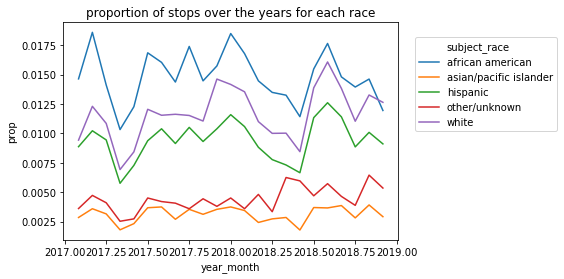

In [19]:
race_year_plot = calc_group_size(sacramento_stops, ['subject_race', 'year', 'month'])

# in order to plot year and month, we make a new column compressing the information
race_year_plot['year_month'] = race_year_plot['year'] + (race_year_plot['month']-1)/12.

ax = sns.lineplot(x='year_month', y='prop', hue='subject_race', data=race_year_plot)
ax.legend(loc = (1.05, 0.5))
ax.set_title('proportion of stops over the years for each race');

From this plot, it seems that for most of the races, the trend over the years has been pretty similar. We note that there seems to be a cyclical pattern where there seems to be a dip in traffic stops near the start of the year. This might be interesting for a different follow-up study. Importantly, we note that the proportion of stops has been largely higher for African Americans over the years, although it seems that the proportion of stops is higher for Whites in the last month of 2018. This does not necessarily mean much though, as it may simply be the case that there are more African Americans in Sacramento. Nonetheless, this is a good start for deeper analysis!

## Benchmark Test
***

### Stop rates

As we alluded to previously, in order to do a baseline comparison, we need to have the population proportions across racial demographics in Sacremento. Let us also just do the analysis for 2018. If you are doing the analysis for a different time period, note that you would have to scale the rates accordingly. We also selected only police officers who had at least 150 stops in total to ensure that we have a sample of police officers who are possibly more experienced, and thus have better judgement in police stop decisions. Moreover, this larger sample size for each police officer will ensure that we can make more robust comparisons of police stop decisions for individual police officers subsequently.

In [20]:
# officer_stop_size = calc_group_size(sacramento_stops, ['OfficerAbra'])
# officer_group = officer_stop_size[officer_stop_size['n'] >= 150]['OfficerAbra'].values
stops_2018 = sacramento_stops[sacramento_stops['date'].apply(lambda date: date.year == 2018)]
stops_2018 = stops_2018[stops_2018['subject_race'] != 'other/unknown']
# stops_2018 = stops_2018[stops_2018['OfficerAbra'].isin(officer_group)]

In [21]:
#https://www.census.gov/quickfacts/fact/table/sacramentocountycalifornia,ca/PST045217
sacramento_population_2018 = 1530615

#White, Black, Hispanic
sacramento_race_percentages = {"white": .448, "african american": .109 , "hispanic": .186, 
                              "asian/pacific islander": .179, 'other/unknown': 0.077}
sacramento_race_demo = pd.DataFrame(sacramento_race_percentages, index=['prop']).T.reset_index()
sacramento_race_demo.columns = ['subject_race', 'prop']
sacramento_race_demo['num_people'] = sacramento_race_demo['prop']*sacramento_population_2018
sacramento_race_demo

,subject_race,prop,num_people
0,white,0.448,685715.520
1,african american,0.109,166837.035
2,hispanic,0.186,284694.390
3,asian/pacific islander,0.179,273980.085
4,other/unknown,0.077,117857.355


Now that we have the population demographics in Sacremento, let us calculate the stop rate per capita for each race. We basically merge the dataframe with total number of stops for each demographic with the dataframe with the total number of residents in each demographic, and divide the two columns. The merge can be easily done with a `merge()` function. The exact details of a merge function requires us to go into detail about the differences between a left merge, right merge, inner merge, outer merge, etc. As such, we would not go into detail. Instead, we would encourage the reader to read the existing [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) for the `merge` function. Whenever you come across a new function, you should always read through the documentation to make sure you understand what the function does. In short, the `merge` function basically concatenates two dataframes across columns, based on a specific shared column. 

In [22]:
sacramento_stops_race = (stops_2018
                         .groupby(['subject_race'], as_index=False)['Idx']
                         .agg({'n': len}))

sacramento_stop_rates = sacramento_stops_race.merge(sacramento_race_demo, how='left', on='subject_race')
sacramento_stop_rates['stop_rate'] = sacramento_stop_rates['n'] / sacramento_stop_rates['num_people']
sacramento_stop_rates.drop(['n', 'num_people', 'prop'], axis=1, inplace=True)
sacramento_stop_rates

,subject_race,stop_rate
0,african american,0.062540
1,asian/pacific islander,0.008190
2,hispanic,0.024142
3,white,0.012762


In [23]:
from calculations import calc_stop_rates
calc_stop_rates(stops_2018, sacramento_race_demo, ['subject_race'])

,subject_race,stop_rate
0,african american,0.062540
1,asian/pacific islander,0.008190
2,hispanic,0.024142
3,white,0.012762


Now we can make better statements about the stop rates for each race! It seems that black drivers are stopped at a rate almost 5 times higher than white drivers!

### Search rates

Let us do the same comparison and analysis for search rates. Instead of using the total population size as a baseline (as in stop rates), it makes sense to instead use the stopped population. As such, search rate is the proportion of stopped people who were subsequently searched. 

**Note**: Some states and municpals also include frisk rates. It may be worth your time to do a similar analysis on frisk rates as well.

In [24]:
(stops_2018
 .groupby('subject_race', as_index=False)['search_conducted']
 .agg({'search_rate': np.mean}))

,subject_race,search_rate
0,african american,0.206345
1,asian/pacific islander,0.070856
2,hispanic,0.150153
3,white,0.076220


In [25]:
from calculations import calc_search_rates
calc_search_rates(stops_2018, ['subject_race'])

,subject_race,search_rate
0,african american,0.206345
1,asian/pacific islander,0.070856
2,hispanic,0.150153
3,white,0.076220


Similar to stop rates, it seems that black drivers are searched almost 3 times as much as white drivers! This seems ridiculous, but let us not make any conclusions without more principled approaches to understanding these statistics. 

### Caveats about the benchmark test

The benchmark test is useful for some quick statistics, but it does not provide any evidence of discrimination. This is because we have not been comparing to the correct baseline. In particular, the stop rates need not necessarily suggest that black drivers have been disproportionately stopped. Some of you may have already noticed, but we have been calculating the rate with respect to the total population within each demographic when we should be calculating the rate with respect to the total number of individuals breaking traffic laws, or exhibiting other criminal behavior in their vehicles. Ideally, if we know that the number of black drivers stopped is disproportionate to the total number of offenders, then we would have strong evidence that there is racial discrimination. Unfortunately, there is no way to have a good measure of the total number of offenders. Using arrest rate would not be a good proxy as arrest rate could similarly be racially skewed as well. 

Search rates are perhaps a safer measure, and it is indeed as what we have observed. The ratio of stop rates for black and white drivers is considerably higher than the ratio of search rates for black and white drivers. Nonetheless, we should conduct more principled analysis of our data before we make any conclusions.

## Outcome Test
***

Following our observations in the benchmark test, it makes sense to analyze the search decision rather than the stop decision. A successful search is when the driver/vehicle is found to own contraband. We define the proportion of successful searches, by race, as the **hit rate**, or otherwise known as the contraband recovery rate. If there is a disproprotion in hit rate across different racial groups, we might have reason to believe that there is discrimination. 

In [26]:
# originally wrong, have to filter just those that were searched
(stops_2018[stops_2018['search_conducted']]
 .groupby('subject_race', as_index=False)['contraband_found']
 .agg({'hit_rate': np.mean}))

,subject_race,hit_rate
0,african american,0.177891
1,asian/pacific islander,0.226415
2,hispanic,0.230620
3,white,0.254873


In [27]:
from calculations import calc_hit_rates
calc_hit_rates(stops_2018, ['subject_race'])

,subject_race,hit_rate
0,african american,0.177891
1,asian/pacific islander,0.226415
2,hispanic,0.230620
3,white,0.254873


We see that hit rates are much lower for black drivers as compared to white drivers. However, this might be because the bar for stopping people (and thus searching them for contraband) is lower in certain police districts. So we should adjust for the locations to check if the disparity really reflect bias. This is indeed the approach taken by the Stanford Open Policing Project. 

However, in the case of the Sacremento dataset, we do not have the police districts data. However, we believe that controling based on the police officer might be just as, or even better, than using police district data. Police officers are assigned to specific police districts, and it is likely that they will stay within the same police district within a specific year. As such, they are reasonable proxies. Moreover, if we can check that police officers have huge disparity in hit rates across different racial groups, this might be even more compelling evidence that there is racial discrimination. 

### Adjusting for police officer

In [28]:
experienced_officers = (stops_2018.groupby(['OfficerAbra', 'subject_race'])[['search_conducted']].sum() >= 5).reset_index()
experienced_officers = experienced_officers[experienced_officers['subject_race'] != 'other/unknown']
experienced_officers = experienced_officers.groupby(['OfficerAbra'])['search_conducted'].sum() >= 3
experienced_officers = experienced_officers[experienced_officers].index
experienced_officers

Int64Index([3684, 3903, 4028, 4065, 4075, 4111, 4114, 4128, 4137, 4160, 4166,
            4192, 4199, 4237, 4256, 4275, 4282, 4376, 4423, 4434, 4444, 4446,
            4486, 4489, 4490, 4514, 4527, 4543, 4546, 4564, 4566, 4620],
           dtype='int64', name='OfficerAbra')

In [29]:
stops_2018_experienced_officers = stops_2018[stops_2018['OfficerAbra'].isin(experienced_officers)]
len(stops_2018_experienced_officers)

6188

In [30]:
hit_rates = (stops_2018_experienced_officers[stops_2018_experienced_officers['search_conducted']]
             .groupby(['subject_race', 'OfficerAbra'], as_index=False)['contraband_found']
             .agg({'hit_rate': np.mean}))
hit_rates.head()

,subject_race,OfficerAbra,hit_rate
0,african american,3684,0.039216
1,african american,3903,0.142857
2,african american,4028,0.195122
3,african american,4065,0.766667
4,african american,4075,0.153846


In [31]:
calc_hit_rates(stops_2018_experienced_officers, ['subject_race', 'OfficerAbra']).head()

,subject_race,OfficerAbra,hit_rate
0,african american,3684,0.039216
1,african american,3903,0.142857
2,african american,4028,0.195122
3,african american,4065,0.766667
4,african american,4075,0.153846


Especially because we are grouping based on the police officer, rather than police districts, we have a huge table that is hard to interpret. Let us plot the hit rates of minority racial groups as compared to white drivers. In order to do so, we would need to reshape our hit rate dataframe such that for each police officer, we have their hit rate on whites and also their hit rates on each of the minority races. This requires some imaginative reshaping that might not be very intuitive. However, the key thing to note is that there are 2 key functions that can reshape pandas dataframe: `pivot_table` and `melt`. They are essentially opposites. The former pivots a dataframe to a wide format; the latter unpivots a dataframe to a long format. We basically want to replicate white hit rates as an additional column for every instance of a minority hit rate. Take your time to try to understand the code, and read up the documentation if you are still not clear!

In [32]:
(pd
 .pivot_table(hit_rates, 
              index='OfficerAbra', 
              columns='subject_race', 
              values='hit_rate', 
              fill_value=0)
 .rename({'white': 'white_hit_rate'}, axis=1).reset_index()
 .melt(id_vars=['OfficerAbra', 'white_hit_rate'], 
       #value_vars=['african american', 'asian/pacific islander', 'hispanic', 'other/unknown'],
       value_name='minority_hit_rate')
 .sort_values('OfficerAbra')
 .reset_index(drop=True)
 .rename({'subject_race': 'minority_race'}, axis=1)).head()

,OfficerAbra,white_hit_rate,minority_race,minority_hit_rate
0,3684,0.125000,african american,0.039216
1,3684,0.125000,hispanic,0.076923
2,3684,0.125000,asian/pacific islander,0.333333
3,3903,0.090909,african american,0.142857
4,3903,0.090909,hispanic,0.000000


In [33]:
from calculations import compare_rates

hit_rates = compare_rates('hit_rate', 
                          hit_rates, 
                          'white', 
                          ['african american', 'hispanic', 'asian/pacific islander'], 
                          'subject_race')
hit_rates.head()

,OfficerAbra,white_hit_rate,minority_group,minority_hit_rate
0,3684,0.125000,african american,0.039216
1,3684,0.125000,hispanic,0.076923
2,3684,0.125000,asian/pacific islander,0.333333
3,3903,0.090909,african american,0.142857
4,3903,0.090909,hispanic,0.000000


Now let us make some comparison plots! For these plots, we would not carry out a tutorial, as it would essentially be a `matplotlib` and `seaborn` tutorial, that could possibly be a stand-alone tutorial. If you are interested, you can take a look at the github code for more details. However, we are essentially using the `FacetGrid` function under `seaborn` to plot several scatterplots based on the minority group categories.

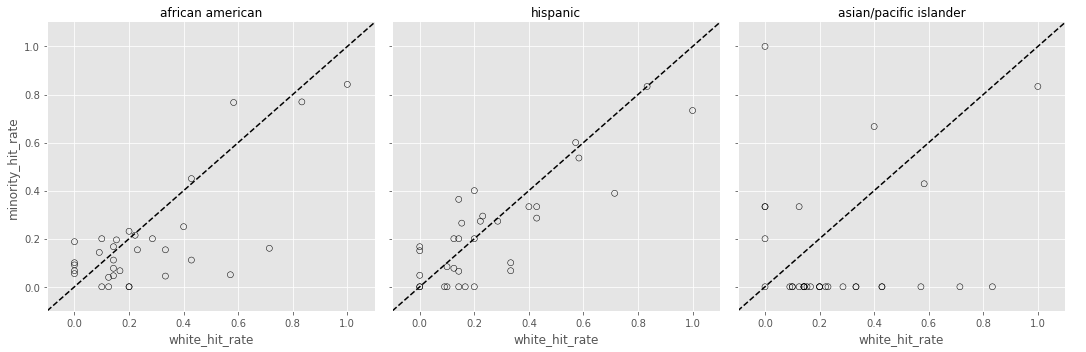

In [34]:
plot_rates_comparison('hit_rate', hit_rates, 'white', 'minority_group', None)

What if the datapoints which are above the 45 degree line (i.e. where minority hit rate is equal to white hit rate) have most of the population within Sacremento? That might suggest that we should give those datapoints more weight. Intuitively, each police officer has different number of total searches. As such, we should include the total number of searches for each police officer as an additional dimension. This would similarly be the case if we were using police districts as well. Let us update our dataframe as well as our plots.

In [35]:
hit_rates_search = hit_rates.merge(calc_group_size(stops_2018_experienced_officers[stops_2018_experienced_officers['search_conducted']], ['OfficerAbra'], False), 
                                   how='left', on='OfficerAbra')
hit_rates_search.rename({'n': 'num_searches'}, axis=1, inplace=True)
hit_rates_search.head()

,OfficerAbra,white_hit_rate,minority_group,minority_hit_rate,num_searches
0,3684,0.125000,african american,0.039216,88
1,3684,0.125000,hispanic,0.076923,88
2,3684,0.125000,asian/pacific islander,0.333333,88
3,3903,0.090909,african american,0.142857,26
4,3903,0.090909,hispanic,0.000000,26


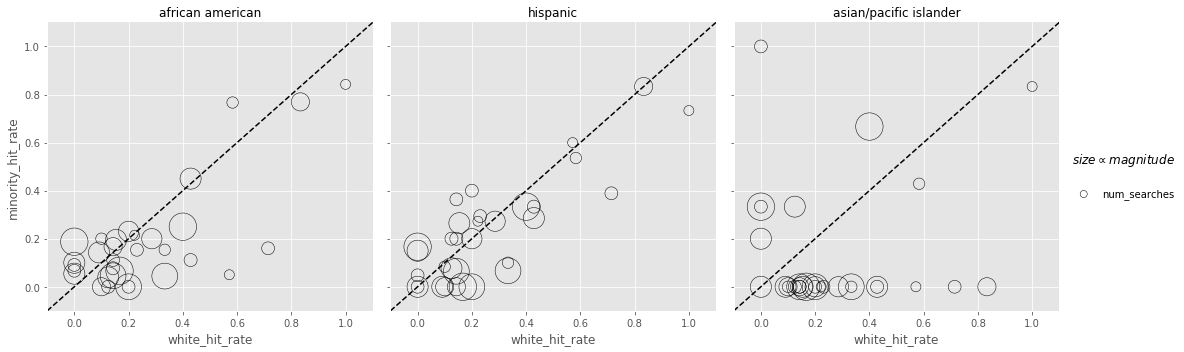

In [36]:
plot_rates_comparison('hit_rate', 
                      hit_rates_search, 
                      'white', 'minority_group', 'num_searches', 
                      marker_size_scale = 0.2)

Due to the huge disparity between the number of searches of each police officer, we decided to not bin the number of searches like in the Stanford Open Policy Project (which was with respect to police districts rather than police officers). This would allow us to better identify the outliers in our dataset. 

It would seem that there is a good spread of hit races across all demographics for most police officers. For Asian/Pacific Islanders/Others, the points seem largely skewed to be below the 45 degree line, and aligned along the x-axis. This is likely because of the low number of searches on those ethnicities. This trend seems more even with Hispanic drivers, and we see that there are police officers with higher white hit rates, and officers with higher hispanic hit rates. However, we notice that there is still a strong concentration of relatively large circles along the $0.0$ x-axis for black drivers in particular. This represents a relatively large number of police officers who have $0$ white hit rates and mostly black hit rates. In particular, there is a decently sized data point (reflecting decent number of searches) at the top left corner for both African American/Hispanic drivers, suggesting that there is a police officer who has always had a hit on a black/hispanic driver. Interestingly, it seems that police officers rarely have a good mix of ethnicity in their hit rates. 

### Caveats about the outcome test

The outcome test is a relatively simple yet compelling way to demonstrate discrimination in an easily understood graph. However, as it only observes outcomes, they actually suffer from the problem of **intra-marginality**. This means that even without discrimination, there might be a disparity across racial groups because of a difference in risk distribution within racial groups. 

Suppose there are only 2 types of white drivers: those who have a 1% chance of carrying contraband, those who have a 80% chance of carrying contraband. Similarly, there are 2 types of black drivers: those who have a 1% chance of carrying contraband, those who have a 60% chance of carrying contraband. If race-neutral police officers only search drivers who have at least a 10% chance of carrying contraband, they will be successful 80% of the time with white drivers, and 60% of the time with black drivers. This is irregardless of the proportion within racial groups of carrying contraband! [https://5harad.com/papers/threshold-test.pdf]

As such, we often use the threshold test, which circumvents the limitations of outcome tests by simultaneously estimating decision thresholds and risk distributions, in order to validate the outcome test. Before we try that out, there is another alternative to assessing bias in stop decisions known as the Veil of Darkness test. It was originally proposed by Grogger and Ridgeway in 2006.

## Threshold Test
***

In [93]:
threshold_dat = (stops_2018_experienced_officers # for ease of analysis, drop other/unknown, and select only 
                 .groupby(['OfficerAbra', 'subject_race'], as_index=False)
                 .agg({'Idx': 'count', # num of stops
                       'search_conducted': 'sum', # num of searches
                       'contraband_found': 'mean'})
                 .rename({'Idx': 'num_stops',
                          'search_conducted': 'num_searches',
                          'contraband_found': 'num_hits'}, axis=1)) # num of hits

threshold_dat = threshold_dat[threshold_dat['num_searches']!=0] # only those with searches
threshold_dat['search_rate'] = threshold_dat['num_searches'] / threshold_dat['num_stops']
threshold_dat['hit_rate'] = threshold_dat['num_hits'] / threshold_dat['num_searches']
threshold_dat.sort_values('OfficerAbra')
threshold_dat.reset_index(drop=True, inplace=True)
threshold_dat['num_searches'] = threshold_dat['num_searches'].astype(int)
threshold_dat['num_hits'] = threshold_dat['num_hits'].astype(int)
threshold_dat.head()

,OfficerAbra,subject_race,num_stops,num_searches,num_hits,search_rate,hit_rate
0,3684,african american,81,51,0,0.629630,0.000484
1,3684,asian/pacific islander,8,3,0,0.375000,0.041667
2,3684,hispanic,49,26,0,0.530612,0.001570
3,3684,white,16,8,0,0.500000,0.007812
4,3903,african american,12,7,0,0.583333,0.011905


In [94]:
"""data {
    int<lower=1> N; // number of observations
    int<lower=1> R; // number of suspect races
    int<lower=1> D; // number of counties

    int<lower=1,upper=R> r[N]; // race of suspect
    int<lower=1,upper=D> d[N]; // county where stop occurred
    int<lower=1> n[N]; // # of stops
    int<lower=0> s[N]; // # of searches
    int<lower=0> h[N]; // # of successful searches (hits)
}
"""

threshold_dat_stan = threshold_dat.copy()

# easier if subject_race and OfficerAbra were encoded as categorical integers
# trick such that values to be replaced are all strings
threshold_dat_stan['OfficerAbra'] = [str(i) for i in threshold_dat_stan.OfficerAbra]
threshold_dat_stan.replace({'OfficerAbra': {val: i + 1 for i, val in enumerate(threshold_dat_stan.OfficerAbra.unique())},
                      'subject_race': {val: i + 1 for i, val in enumerate(threshold_dat_stan.subject_race.unique())}},
                      inplace=True)
threshold_dat_stan.columns = ['d', 'r', 'n', 's', 'h', 'search_rate', 'hit_rate']
threshold_dat_stan.head()

,d,r,n,s,h,search_rate,hit_rate
0,1,1,81,51,0,0.629630,0.000484
1,1,2,8,3,0,0.375000,0.041667
2,1,3,49,26,0,0.530612,0.001570
3,1,4,16,8,0,0.500000,0.007812
4,2,1,12,7,0,0.583333,0.011905


In [39]:

threshold_dat_dict = {
                    'd': list(threshold_dat_stan['d']),
                    'r': list(threshold_dat_stan['r']),
                    'n': list(threshold_dat_stan['n']),
                    's': list(threshold_dat_stan['s']),
                    'h': list(threshold_dat_stan['h'])
                     }
threshold_dat_dict['N'] = len(threshold_dat_stan)
threshold_dat_dict['R'] = len(threshold_dat_stan['r'].unique())
threshold_dat_dict['D'] = len(threshold_dat_stan['d'].unique())

In [41]:
import os
os.environ['MACOSX_DEPLOYMENT_TARGET'] = '10.9'

sm = pystan.StanModel(file = 'model.stan');

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ba3a30c7e329693c789bb873d21a2ab NOW.


In [43]:
fit = sm.sampling(data=threshold_dat_dict, iter=10000, chains=2, algorithm = 'NUTS', control={'max_treedepth': 10,
                                                                                             'adapt_delta':0.9}
                 )

In [ ]:
# import pickle
# with open("race_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : sm, 'fit' : fit}, f, protocol=-1)

    
# with open("race_model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
# fit_loaded = data_dict['fit']

# fit_loaded

In [44]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_3ba3a30c7e329693c789bb873d21a2ab.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t[1]       0.12  6.3e-3    0.1 5.3e-3   0.05    0.1   0.17   0.38    266   1.01
sigma_t[2]        0.4    0.02   0.33   0.02   0.15   0.32   0.56   1.23    301   1.01
sigma_t[3]       0.16    0.01   0.13 9.8e-3   0.06   0.12   0.23    0.5    168    1.0
sigma_t[4]       0.31    0.02   0.24   0.02   0.13   0.27   0.44   0.89    194    1.0
mu_phi_d        -3.02    0.05   0.49  -4.01  -3.36  -3.03  -2.67  -2.11    114    1.0
sigma_phi_d      0.47    0.02   0.11   0.22   0.41   0.47   0.54   0.69     48   1.02
mu_lambda_d       3.1    0.05   0.68   1.79   2.63   3.09   3.56   4.49    158    1.0
sigma_lambda_d   0.43    0.05    0.3   0.02   0.18   0.38   0.65   1.05     40   

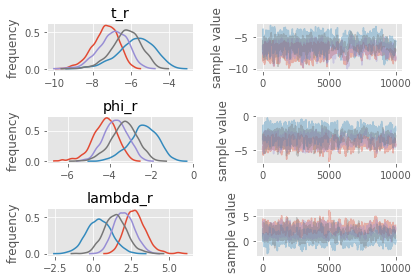

In [90]:
fit.plot(['t_r', 'phi_r', 'lambda_r']);
plt.tight_layout();

In [145]:
threshold_dat['threshold_rate'] = fit.extract()['t_i'].mean(axis = 0)

In [148]:
threshold_rates = compare_rates('threshold_rate', threshold_dat[['OfficerAbra', 'subject_race', 'threshold_rate']], 'white', ['african american', 'hispanic', 'asian/pacific islander'], 
                          'subject_race')
threshold_rates_search = threshold_rates.merge(calc_group_size(stops_2018_experienced_officers[stops_2018_experienced_officers['search_conducted']], ['OfficerAbra'], False), 
                                   how='left', on='OfficerAbra')
threshold_rates_search.rename({'n': 'num_searches'}, axis=1, inplace=True)
threshold_rates_search.head()

,OfficerAbra,white_threshold_rate,minority_group,minority_threshold_rate,num_searches
0,3684,0.002581,african american,0.000802,88
1,3684,0.002581,hispanic,0.001328,88
2,3684,0.002581,asian/pacific islander,0.005344,88
3,3903,0.002374,african american,0.000793,26
4,3903,0.002374,hispanic,0.001252,26


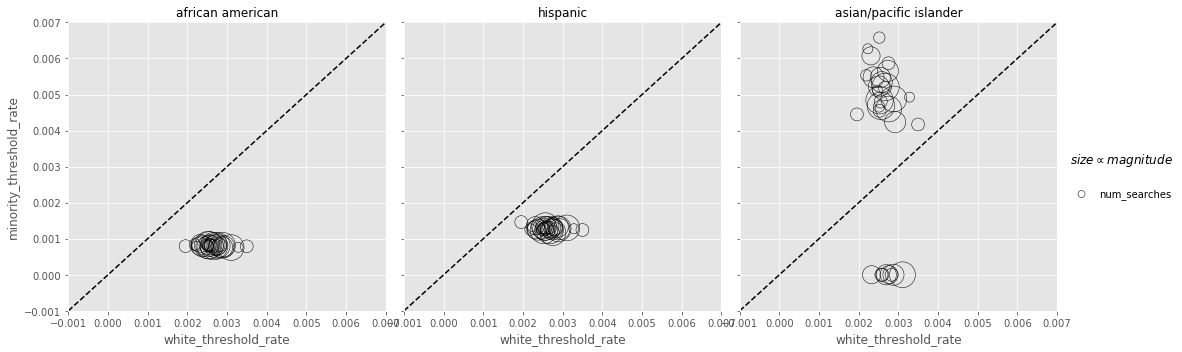

In [149]:
plot_rates_comparison('threshold_rate', 
                      threshold_rates_search, 
                      'white', 'minority_group', 'num_searches', 
                      marker_size_scale = 0.2, min_lim = -0.001, max_lim = 0.007)

In [49]:
# import pickle
# with open("race_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : sm, 'fit' : fit}, f, protocol=-1)

    
# with open("race_model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
# fit_loaded = data_dict['fit']

# fit_loaded

## Veil of Darkness test
***

The Veil of Darkness test works on the hypothesis that police officers who are racial profiling are less likely to identify a driver's race when it is dark. As such, under this hypothesis, we would expect that if stops made after dark had a smaller proportion of black drivers than during daytime, it might be evidence that at least some police officers are racial profiling drivers. Nonetheless, there are many things that can be correlated with time, i.e. enforcement patterns, driving schedule. As such, we would only compare within an inter-twilight period.

The inter-twilight period is essentially the period of time between the earliest dusk time and the latest dusk time (within the period of interest). As the 30 minute period between sunset and dusk has ambiguous daylight, we filter out stops in those times. 

This allows us to compare times that had daylight at some point in the studied period but were dark at another point in the studied period. Intuitively, we would be able to compare the same group of drivers and police officers, and thus observe the effect of darkness of police stop decisions. 

We have written a function `calc_sunset_times` that taps on the `astral` package to calculate both the sunset and dusk times given a specific longitude and latitude. 

**Note**: As the number of stops will decrease greatly after the filtering of twilight hours, we will be using the full dataset instead of just the 2018 data for Sacramento. This is because there is huge variability in our results with just the 2018 data due to the small dataset size.

In [48]:
sacramento_lat = 38.5816
sacramento_long = -121.4944

# calculate sunset and dusk times in sacremento
from calculations import calc_sunset_times
sunset_time = calc_sunset_times(sacramento_stops, sacramento_lat, sacramento_long, 'UTC')
sunset_time.head()

,date,sunset,dusk,sunset_minute,dusk_minute
0,2017-03-22,02:19:09,02:45:39,139,165
1,2017-03-15,02:12:22,02:38:48,132,158
2,2017-03-14,02:11:23,02:37:49,131,157
3,2017-03-10,02:07:25,02:33:53,127,153
4,2017-03-09,02:06:25,02:32:54,126,152


Given the dataframe of sunset and dusk times, we can then filter our original dataframe such that we only keep the stops within the inter-twilight period, and excluding the ambiguous period. 

In [55]:
vod_stops = sacramento_stops.merge(sunset_time, how='left' ,on='date')
vod_stops['minute'] = vod_stops['time'].apply(lambda t: t.hour*60 + t.minute)
vod_stops['minutes_after_dark'] = vod_stops['minute'] - vod_stops['dusk_minute']
vod_stops['is_dark'] = (vod_stops['minute'] > vod_stops['dusk_minute']).astype('int')

# filter to intertwilight period
min_dusk_minute = vod_stops['dusk_minute'].min()
max_dusk_minute = vod_stops['dusk_minute'].max()
vod_stops = vod_stops[(vod_stops['minute'] >= min_dusk_minute) & (vod_stops['minute'] <= max_dusk_minute)]

# remove ambiguous period
vod_stops = vod_stops[~((vod_stops['minute'] > vod_stops['sunset_minute']) & (vod_stops['minute'] < vod_stops['dusk_minute']))]

print(vod_stops.shape)
vod_stops['time'].min(), vod_stops['time'].max()

(7110, 50)


(datetime.time(1, 14), datetime.time(4, 6))

In [56]:
from calculations import get_veil_of_darkness_observations
vod_stops = get_veil_of_darkness_observations(sacramento_stops, sunset_time)

In [57]:
print(vod_stops.shape)
vod_stops['time'].min(), vod_stops['time'].max()

(7110, 50)


(datetime.time(1, 14), datetime.time(4, 6))

We still have a sizeable number of stops to do our analysis. Note that we are doing our calculations in UTC time. As such, the twilight time ranges that we have are actually pretty reasonable. We can see that the earliest time we have is actually 6:15pm (Pacific Daylight Time), and the latest time we have is actually 9.05pm. Let us check for the proportion of stops within this filtered time period when it was dark, as compared to when it was not dark yet, i.e. 7-715pm.

In [58]:
vod_test = vod_stops[(vod_stops['time'] >= datetime.time(2, 0)) & (vod_stops['time'] <= datetime.time(2, 15))]
vod_count = vod_test.groupby('is_dark')['Idx'].agg({'total_count': 'count'})
vod_count =(vod_test
            .groupby(['is_dark', 'subject_race'], as_index=False)['Idx']
            .agg({'race_count': 'count'})
            .merge(vod_count, how='left', on='is_dark'))
vod_count['prop'] = vod_count['race_count'] / vod_count['total_count']
vod_count.drop(['race_count', 'total_count'], axis=1, inplace=True)
vod_prop = vod_count.pivot_table(values='prop', index='is_dark', columns='subject_race')
vod_prop

subject_race,african american,asian/pacific islander,hispanic,other/unknown,white
is_dark,,,,,
0,0.429952,0.038647,0.263285,0.077295,0.190821
1,0.342466,0.075342,0.246575,0.075342,0.260274


In [59]:
from calculations import calc_vod_rate
calc_vod_rate(vod_stops, '02:00', '02:15')

subject_race,african american,asian/pacific islander,hispanic,other/unknown,white
is_dark,,,,,
0,0.429952,0.038647,0.263285,0.077295,0.190821
1,0.342466,0.075342,0.246575,0.075342,0.260274


It seems that there is a huge disparity between the stop rates when it is dark and when it is not dark! In particular, the stop rates are around 8% lower for black drivers and around 7% higher for white drivers when it is dark. According to our veil of darkness hypothesis, it seems that police officers might be engaging in racial profiling. However, we are unable to determine the extent of the racial profiling. Moreover, we have only looked at a specific time period, so let us not come to any quick conclusions...

A simple way to check for robustness of results is to use a logistic regression for the whole twilight period. Specifically, we are measuring the impact of darkness on the indicator of whether a person is in a minority race. This impact measure is called the 'coefficient of darkness'. We included a natural spline for minutes to control for the time factor.

In [60]:
is_black = (vod_stops['subject_race'] == 'african american').astype(int)

X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                 7110
Model:                            GLM   Df Residuals:                     7103
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4771.9
Date:                Fri, 03 May 2019   Deviance:                       9543.7
Time:                        19:55:12   Pearson chi2:                 7.11e+03
No. Iterations:                   100   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark              -0.1172      0.060     -1.964      0.050      -0.234      -0.000
Intercept            -0.3021   

The 'coefficient of darkness' negative, suggesting that it is negatively correlated with the indicator of whether the driver is black. This means that if it is dark, there is lower likelihood that the stopped driver is black. Importantly, the 'coefficient of darkness' is statistically significant and has relatively large size. The Veil of Darkness test seems to suggest that there is racial profiling in Sacramento traffic stops.

In [61]:
# remove officer with too few stops
officer_sizes = calc_group_size(vod_stops, ['OfficerAbra'])
officer_sizes = officer_sizes[officer_sizes['n'] >= 75]
officer_vod_stops = vod_stops[vod_stops['OfficerAbra'].isin(officer_sizes['OfficerAbra'].values)]

print(officer_vod_stops.shape)

(1926, 50)


In [62]:
len(officer_sizes)

17

In [66]:
is_black = (officer_vod_stops['subject_race'] == 'african american').astype(int)

X = officer_vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": officer_vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
X = X.merge(pd.get_dummies(officer_vod_stops['OfficerAbra']), left_index = True, right_index = True)

logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                 1926
Model:                            GLM   Df Residuals:                     1903
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1199.9
Date:                Fri, 03 May 2019   Deviance:                       2399.7
Time:                        19:56:58   Pearson chi2:                 1.93e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark               0.0750      0.127      0.592      0.554      -0.173       0.324
Intercept            -0.1672   

### Caveats about the Veil of Darkness test

It is important to note that we have only shown that there is relationship between the race of the driver and whether the driver was stopped during the twilight period. While this is the key idea behind the test, it also becomes a limiting factor as it may not be fair to extrapolate and make conclusions about the same relationship at all times of the day. 

Moreover, we have done a very simple regression model. There are many other factors that correlate with race and could thus affect the police officers stop decisions. The vehicle make, year, and model could possibly correlate with race, and police officers can infer about the race of the driver even if low visibility. The presence of street lamps, or even just moonlight, can also weaken our hypothesis about the visibility at night. Importantly, darkness is a function of date. The test may suggest the presence of discrimination if changes in driving behavior throughout the year correlates with race. 

As such, the veil of darkness is not the perfect test, but it nonetheless provides us a useful measure of bias in stop decisions.

***

## Gender Extension

The two most commonly touted factors of discrimination are gender and race. We were curious about the presence of gender discrimination in police stops, and decided to do the analysis for the Sacramento dataset.

In [39]:
calc_group_size(sacramento_stops, 'Gender')

,Gender,n,prop
0,F,19687,0.332736
1,M,39480,0.667264


There is a substantially greater number of male drivers as compared to female drivers. As such, we should once again be looking at the proportion with regard to the actual proportion of males and females in Sacramento.

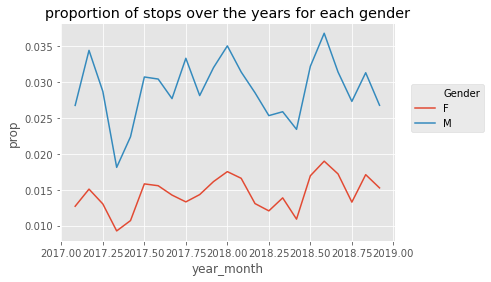

In [40]:
gender_year_plot = calc_group_size(sacramento_stops, ['Gender', 'year', 'month'])

# in order to plot year and month, we make a new column compressing the information
gender_year_plot['year_month'] = gender_year_plot['year'] + (gender_year_plot['month']-1)/12.

ax = sns.lineplot(x='year_month', y='prop', hue='Gender', data=gender_year_plot)
ax.legend(loc = (1.05, 0.5))
ax.set_title('proportion of stops over the years for each gender');

The the proportion of stops seem to largely follow the same pattern for male and female drivers over the years. This once again highlights that there might be a time factor to police stops.

In [41]:
sacramento_gender_percentages = {"F": .511, "M": .489}
sacramento_gender_demo = pd.DataFrame(sacramento_gender_percentages, index=['prop']).T.reset_index()
sacramento_gender_demo.columns = ['Gender', 'prop']
sacramento_gender_demo['num_people'] = sacramento_gender_demo['prop']*sacramento_population_2018
sacramento_gender_demo

,Gender,prop,num_people
0,F,0.511,782144.265
1,M,0.489,748470.735


In [42]:
calc_stop_rates(stops_2018, sacramento_gender_demo, ['Gender'])

,Gender,stop_rate
0,F,0.012250
1,M,0.025012


In [43]:
calc_search_rates(stops_2018, ['Gender'])

,Gender,search_rate
0,F,0.050204
1,M,0.188558


We did the same benchmark test with regard to stop and search rates. Interestingly, it seems that the stops rates for male drivers are significantly higher (around double). The search rates are also significantly lower (around four times). If the latter was referring to frisk rates, that might be reasonable considering that police officers would probably not be allowed to frisk a driver of the opposite gender. However, there seems to be no good reason why female drivers should be searched at a significantly lower rate. Nonetheless, let us look at the data more rigorously.

In [45]:
hit_rates_gender = calc_hit_rates(stops_2018_experienced_officers, ['Gender', 'OfficerAbra'])
hit_rates_gender = compare_rates('hit_rate', 
                                 hit_rates_gender, 
                                 'M', 
                                 ['F'], 
                                 'Gender')
hit_rates_gender_search = hit_rates_gender.merge(calc_group_size(stops_2018[stops_2018['search_conducted']], ['OfficerAbra'], False), 
                                   how='left', on='OfficerAbra')
hit_rates_gender_search.rename({'n': 'num_searches'}, axis=1, inplace=True)
hit_rates_gender_search.head()

,OfficerAbra,M_hit_rate,minority_group,minority_hit_rate,num_searches
0,3684,0.070588,F,0.000000,88
1,3903,0.050000,F,0.166667,26
2,4028,0.216000,F,0.000000,133
3,4065,0.619048,F,0.600000,89
4,4075,0.178571,F,0.200000,33


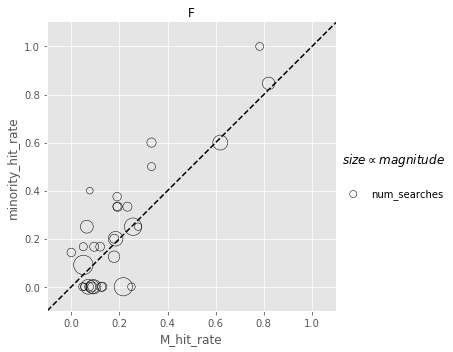

In [46]:
plot_rates_comparison('hit_rate', 
                      hit_rates_gender_search, 
                      'M', 'minority_group', 'num_searches', 
                      marker_size_scale = 0.4)

It seems that police officers either hit just on male drivers (and thus have points with 0 minority hit rate and substantial male hit rates), or hit on more female drivers as compared to male drivers. This can be seen by the fact that there are rarely any points below the 45 degree line that are not along the x axis. This seems to suggest that there may be a group of police officers who exclusively do not hit on female drivers. One may assume that if the points along the x-axis included some hits on female drivers, we may observe a more fair distribution of hits around the 45 degree line. There may be some positive discrimination against female drivers...

In [65]:
is_female = (vod_stops['Gender'] == 'F').astype(int)

X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
logit_model = sm.GLM(is_female, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Gender   No. Observations:                 7110
Model:                            GLM   Df Residuals:                     7103
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4199.0
Date:                Fri, 03 May 2019   Deviance:                       8397.9
Time:                        19:55:59   Pearson chi2:                 7.11e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark               0.2980      0.065      4.557      0.000       0.170       0.426
Intercept            -0.9623   

In [67]:
is_female = (officer_vod_stops['Gender'] == 'F').astype(int)

X = officer_vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": officer_vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)
X = X.merge(pd.get_dummies(officer_vod_stops['OfficerAbra']), left_index = True, right_index = True)

logit_model = sm.GLM(is_female, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Gender   No. Observations:                 1926
Model:                            GLM   Df Residuals:                     1903
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -994.69
Date:                Fri, 03 May 2019   Deviance:                       1989.4
Time:                        19:58:12   Pearson chi2:                 1.92e+03
No. Iterations:                    15   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark               0.3761      0.142      2.657      0.008       0.099       0.654
Intercept            -1.1487   

In [58]:
gender_threshold_dat = (stops_2018_experienced_officers
                 .groupby(['OfficerAbra', 'Gender'], as_index=False)
                 .agg({'Idx': 'count', # num of stops
                       'search_conducted': 'sum', # num of searches
                       'contraband_found': 'mean'})
                 .rename({'Idx': 'num_stops',
                          'search_conducted': 'num_searches',
                          'contraband_found': 'num_hits'}, axis=1)) # num of hits

gender_threshold_dat = gender_threshold_dat[gender_threshold_dat['num_searches']!=0] # only those with searches
gender_threshold_dat['search_rate'] = gender_threshold_dat['num_searches'] / gender_threshold_dat['num_stops']
gender_threshold_dat['hit_rate'] = gender_threshold_dat['num_hits'] / gender_threshold_dat['num_searches']
gender_threshold_dat.sort_values('OfficerAbra')
gender_threshold_dat.reset_index(drop=True, inplace=True)
gender_threshold_dat['num_searches'] = gender_threshold_dat['num_searches'].astype(int)
gender_threshold_dat['num_hits'] = gender_threshold_dat['num_hits'].astype(int)

gender_threshold_dat['OfficerAbra'] = [str(i) for i in gender_threshold_dat.OfficerAbra]
gender_threshold_dat.replace({'OfficerAbra': {val: i + 1 for i, val in enumerate(gender_threshold_dat.OfficerAbra.unique())},
                      'Gender': {val: i + 1 for i, val in enumerate(gender_threshold_dat.Gender.unique())}},
                      inplace=True)

gender_threshold_dat.columns = ['d', 'r', 'n', 's', 'h', 'search_rate', 'hit_rate']
gender_threshold_dat.head()

gender_threshold_dat_dict = {
                    'd': list(gender_threshold_dat['d']),
                    'r': list(gender_threshold_dat['r']),
                    'n': list(gender_threshold_dat['n']),
                    's': list(gender_threshold_dat['s']),
                    'h': list(gender_threshold_dat['h'])
                     }
gender_threshold_dat_dict['N'] = len(gender_threshold_dat)
gender_threshold_dat_dict['R'] = len(gender_threshold_dat['r'].unique())
gender_threshold_dat_dict['D'] = len(gender_threshold_dat['d'].unique())

In [59]:
gender_fit = sm.sampling(data=gender_threshold_dat_dict, iter=10000, chains=2, algorithm = 'NUTS', control={'max_treedepth': 10,
                                                                                             'adapt_delta':0.9}
                 )

In [60]:
gender_fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_3ba3a30c7e329693c789bb873d21a2ab.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t[1]       0.24    0.24   0.25 4.4e-3   0.01   0.16   0.47   0.66      1   4.55
sigma_t[2]        0.3    0.02   0.03   0.26   0.28   0.29   0.32   0.35      2   1.63
mu_phi_d        -3.88    1.18   1.18  -5.14  -5.08  -3.88   -2.7  -2.62      1  39.46
sigma_phi_d      0.28    0.27   0.27 5.8e-3 9.0e-3   0.26   0.55   0.57      1  27.35
mu_lambda_d      4.91    1.77   1.77   2.92    3.1   5.04   6.66   6.78      1  24.21
sigma_lambda_d   0.06  5.8e-3   0.02   0.03   0.05   0.06   0.07   0.09      7   1.11
t_r[1]          -7.76    1.69   1.69  -9.63  -9.43  -7.77  -6.08  -5.87      1  24.47
t_r[2]          -9.23    0.68   0.69  -9.96   -9.9  -9.47  -8.51  -8.22      1   